### SVHN(Street View Home Number).




In [3]:
import tensorflow as tf
from scipy.io import loadmat

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Load the dataset from your Drive folder

test = loadmat('/content/gdrive/MyDrive/SVHM dataset/test_32x32.mat')
train = loadmat('/content/gdrive/MyDrive/SVHM dataset/train_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset


In [100]:
import tensorflow as tf
# import keras
from scipy.io import loadmat
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [101]:
train_data =np.array(train['X'])
test_data = np.array(test['X'])


train_labels = train['y']
test_labels = test['y']

In [102]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [103]:
train_data.shape

(32, 32, 3, 73257)

In [104]:
train_data = np.moveaxis(train_data, -1, 0)

In [105]:
train_data.shape

(73257, 32, 32, 3)

In [106]:
test_data = np.moveaxis(test_data, -1, 0)

Label:  [1]
Label:  [9]
Label:  [2]
Label:  [3]
Label:  [2]
Label:  [5]
Label:  [9]
Label:  [3]
Label:  [3]
Label:  [1]


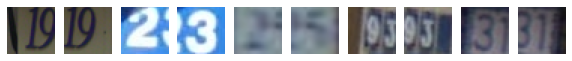

In [107]:
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(train_data[i])
    print('Label: ',train_labels[i])

In [108]:
from skimage import color
trainGray = color.rgb2gray(train_data)
testgray = color.rgb2gray(test_data)

In [109]:
testgray.shape

(26032, 32, 32)

Label:  [1]
Label:  [9]
Label:  [2]
Label:  [3]
Label:  [2]
Label:  [5]
Label:  [9]
Label:  [3]
Label:  [3]
Label:  [1]


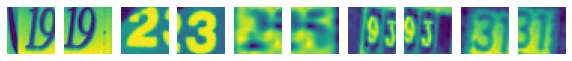

In [110]:
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(trainGray[i])
    print('Label: ', train_labels[i])

## 2. MLP neural network classifier


In [111]:
def model_mlp(input_shape):
    
    model = Sequential()
    model.add(Dense(128, activation = 'relu', input_shape = (input_shape),))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(11, activation = 'softmax'))
    
    
    model.compile(loss = 'sparse_categorical_crossentropy',
                  
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-04),
                  metrics =['accuracy'])
    
    
    return model

In [112]:
MLP_model = model_mlp(trainGray[0].shape)

In [113]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

In [114]:
MLP_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32, 128)           4224      
                                                                 
 flatten_4 (Flatten)         (None, 4096)              0         
                                                                 
 dense_17 (Dense)            (None, 128)               524416    
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 11)               

In [115]:
def get_checkpoint_best_only():
    checkpoints_best_only = ModelCheckpoint(filepath = 'checkpoints_best_only/checkpoint_MLP',
                                           save_weights_only= True,
                                           save_best_only= True,
                                           monitor='val_accuracy',
                                           mode = 'max',
                                           verbose = 1)
    
    
    return checkpoints_best_only


    
    
def earlystopping():
    
    earlystopping = EarlyStopping(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose =1,
                                 restore_best_weights= True)
    return earlystopping

In [116]:
get_best_check_points = get_checkpoint_best_only()
earlystopping = earlystopping()

In [117]:
callbacks =[get_best_check_points, earlystopping, lr_scheduler]

In [118]:
history =MLP_model.fit(trainGray, train_labels,batch_size = 128, callbacks=callbacks, validation_data=(testgray,test_labels), epochs = 20)

Epoch 1/20
568/573 [============================>.] - ETA: 0s - loss: 2.1292 - accuracy: 0.2452
Epoch 00001: val_accuracy improved from -inf to 0.39217, saving model to checkpoints_best_only/checkpoint_MLP
573/573 [==============================] - 5s 8ms/step - loss: 2.1266 - accuracy: 0.2463 - val_loss: 1.8385 - val_accuracy: 0.3922 - lr: 1.0000e-04
Epoch 2/20
568/573 [============================>.] - ETA: 0s - loss: 1.4493 - accuracy: 0.5327
Epoch 00002: val_accuracy improved from 0.39217 to 0.59834, saving model to checkpoints_best_only/checkpoint_MLP
573/573 [==============================] - 5s 8ms/step - loss: 1.4471 - accuracy: 0.5335 - val_loss: 1.3071 - val_accuracy: 0.5983 - lr: 1.2589e-04
Epoch 3/20
571/573 [============================>.] - ETA: 0s - loss: 1.1186 - accuracy: 0.6553
Epoch 00003: val_accuracy improved from 0.59834 to 0.65151, saving model to checkpoints_best_only/checkpoint_MLP
573/573 [==============================] - 4s 7ms/step - loss: 1.1184 - accuracy

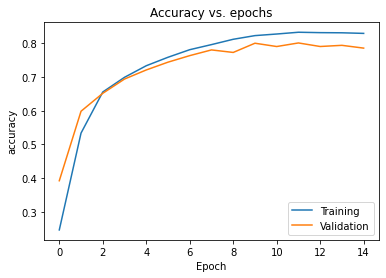

In [119]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

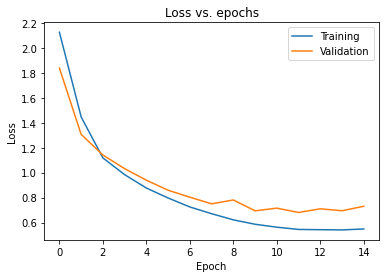

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 3. CNN neural network classifier


In [26]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [60]:
def model_1(input_shape, weight_decay,):
    model = Sequential()
    
    
    
    
    model.add(Conv2D(32, (3,3),
                     padding = 'SAME',
                     activation = 'relu', 
                     input_shape =(32,32,1),))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size= (2,2)))
    model.add(Dropout(weight_decay))
    
    
    
    
    model.add(Conv2D(64, (3,3),
                    padding = 'SAME',
                    activation = 'relu',
                    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(weight_decay))
    
    
    #fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(weight_decay))
    model.add(Dense(10, activation ='softmax'))
    
    
    
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad = True),
                 metrics = ['accuracy'])
              
              
    return model

In [61]:
model = model_1(trainGray[0].shape, 0.5)

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 64)      

In [63]:
datagen = ImageDataGenerator(rotation_range= 8,
                             zoom_range = [0.4, 1.04],
                             height_shift_range = 0.25,
                             shear_range = 0.15)

In [64]:
def get_checkpoint_best_only1():
    checkpoints_best_only = ModelCheckpoint(filepath = 'checkpoints_best_only/checkpoint',
                                           save_weights_only= True,
                                           save_best_only= True,
                                           monitor='val_accuracy',
                                           mode = 'max',
                                           verbose = 1)
    
    
    return checkpoints_best_only


    
    
def earlystopping1():
    
    earlystopping = EarlyStopping(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose =1,
                                 restore_best_weights= True)
    return earlystopping

In [65]:
checkpoints_best_only1 = get_checkpoint_best_only1()
earlystopping1 = earlystopping1()
callbacks1 =[checkpoints_best_only1, earlystopping1]

In [66]:
trainGray = trainGray.reshape(73257, 32, 32,1)

In [67]:
trainGray.shape

(73257, 32, 32, 1)

In [68]:
testgray = testgray.reshape(26032, 32, 32,1)

In [70]:
history1 = model.fit(trainGray, train_labels, batch_size=128,
          epochs = 30, callbacks = callbacks1, validation_data = (testgray, test_labels), verbose = True)

Epoch 1/30
571/573 [============================>.] - ETA: 0s - loss: 2.0965 - accuracy: 0.2302
Epoch 00001: val_accuracy improved from -inf to 0.36736, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 12s 19ms/step - loss: 2.0962 - accuracy: 0.2303 - val_loss: 1.7773 - val_accuracy: 0.3674
Epoch 2/30
572/573 [============================>.] - ETA: 0s - loss: 1.5927 - accuracy: 0.4240
Epoch 00002: val_accuracy improved from 0.36736 to 0.73494, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 10s 18ms/step - loss: 1.5926 - accuracy: 0.4240 - val_loss: 0.8567 - val_accuracy: 0.7349
Epoch 3/30
571/573 [============================>.] - ETA: 0s - loss: 1.0571 - accuracy: 0.6451
Epoch 00003: val_accuracy improved from 0.73494 to 0.82383, saving model to checkpoints_best_only/checkpoint
573/573 [==============================] - 10s 17ms/step - loss: 1.0566 - accuracy: 0.6453 - val_loss: 0.6106 - val_accura

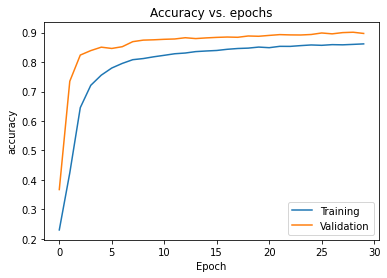

In [73]:
try:
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
except KeyError:
    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

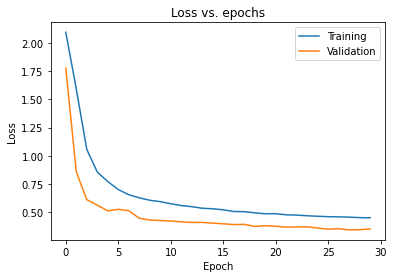

In [74]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Get model predictions


In [76]:
model.load_weights('checkpoints_best_only/checkpoint')

In [77]:
import random

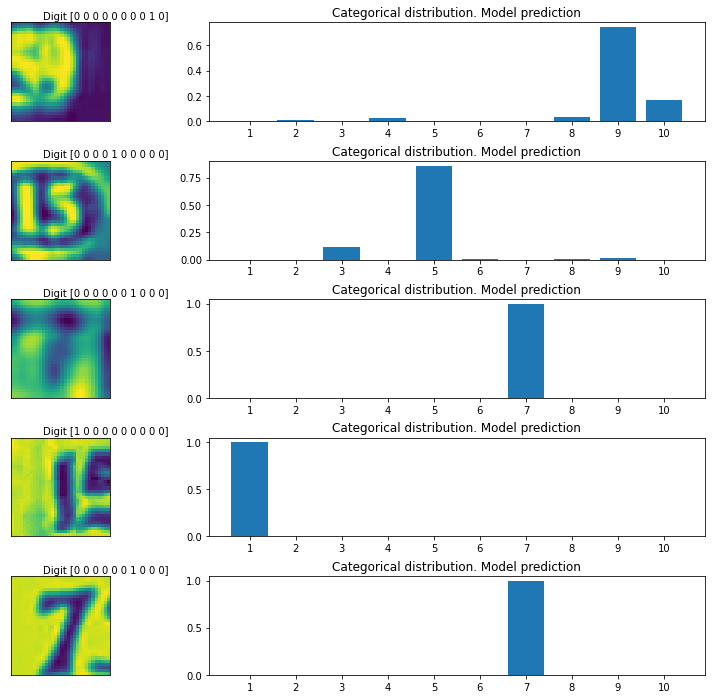

In [80]:
num_test_images = testgray.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = testgray[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

In [121]:
MLP_model.load_weights('checkpoints_best_only/checkpoint_MLP')

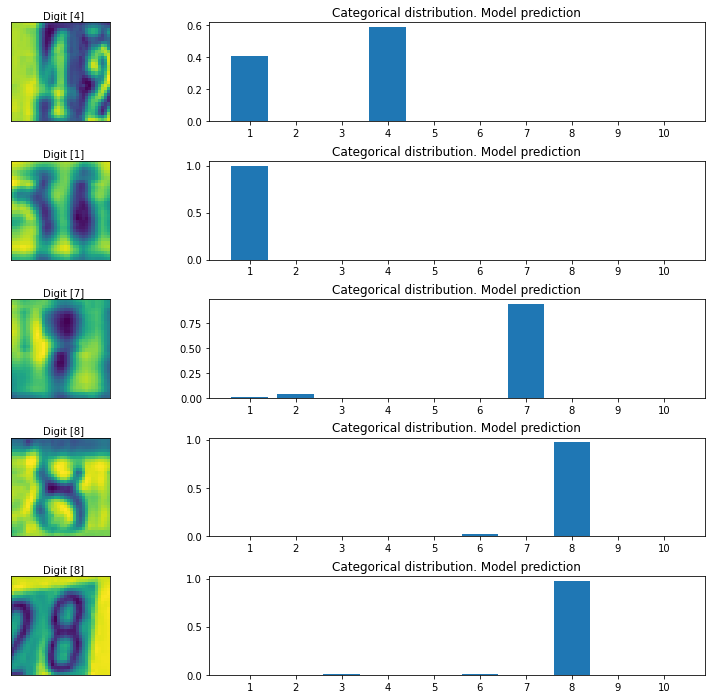

In [123]:
num_test_images = testgray.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = testgray[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()